# Photic Zone: Low-data-rate sensor profile reduction


Profiler sensors produce profiles that can be described approximately with a few parameters. This notebook takes up
this simplification / reduction process starting again with CTD data. See notebook Ocean 01 A for the source material.


In [9]:
import os, sys, time, glob, warnings
from IPython.display import clear_output             # use inside loop with clear_output(wait = True) followed by print(i)
warnings.filterwarnings('ignore')
this_dir = os.getcwd()
data_dir = this_dir + '/../data'

from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors
import numpy as np, pandas as pd, xarray as xr
from numpy import datetime64 as dt64, timedelta64 as td64

# convenience functions abbreviating 'datetime64' and so on
def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')
def day_of_month_to_string(d): return str(d) if d > 9 else '0' + str(d)

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


Jupyter Notebook running Python 3


### The problems to solve

- Read the month of data
- Derive a list of start / apex / end times for all of the profiles
    - Annotate the pH profile stops, both midnight and noon local
    - Note rest intervals on the 200m platform are also important
- For (sensor type, ascent/descent, continuous/interval, night/day)...
    - Extra the data with time and depth
    - Smooth the data
    - Calculate first and second derivatives
    - Calculate a set of characterization values
        - Start depth
        - Depth at which signal slope (low pass) changes
        - Inflection
        - Max slope
        - Upper layer thickness
        - Boxcar standard deviation
        - And like that; and infer lenses if they are present
- Dimension is now roughly speaking a collection of profiles by sensors
    - Compare same profile different sensors
    - Compare different profile same sensors
    - Review the Arctic Great Rivers data in the sense of "29-observation axis"

...


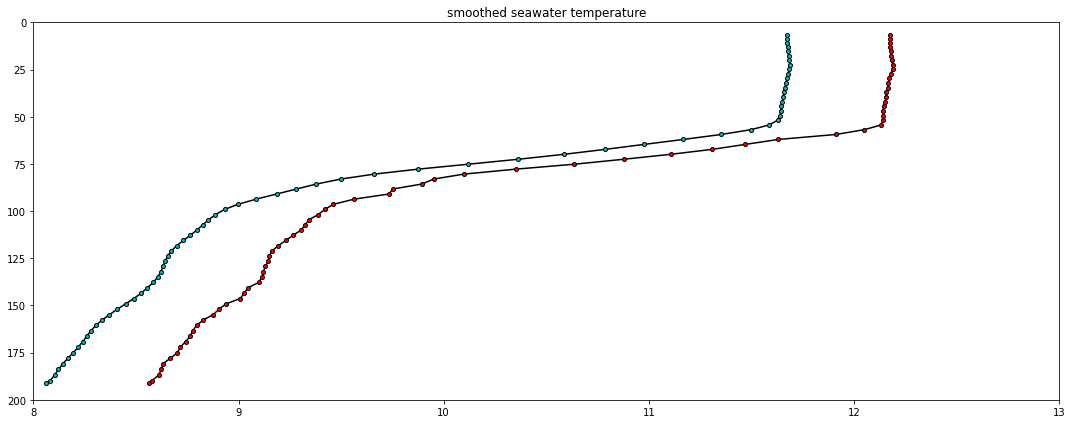

In [10]:
osb_ctd_nc_file = "./data/rca/ctd/osb_ctd_jan2019_1min.nc"
ds_CTD = xr.open_dataset(osb_ctd_nc_file)

temperature_upper_bound = 12.
temperature_lower_bound = 7.
salinity_upper_bound = 35.
salinity_lower_bound = 32.
dissolved_oxygen_upper_bound = 300
dissolved_oxygen_lower_bound = 100


# using UTC time ranges including HH:MM

day_of_month_a = '01'
day_of_month_b = '01'

time0 = dt64('2019-01-' + day_of_month_a + 'T00:26:05')
time1 = dt64('2019-01-' + day_of_month_b + 'T01:37:55')

temperature_upper_bound = 13.
temperature_lower_bound = 8.
salinity_upper_bound = 35.
salinity_lower_bound = 32.
dissolved_oxygen_upper_bound = 300
dissolved_oxygen_lower_bound = 100

ds_CTD_time_slice = ds_CTD.sel(time=slice(time0, time1))

sensor_t = ds_CTD_time_slice.seawater_temperature
sensor_d = ds_CTD_time_slice.seawater_pressure

n_passes = 3
s_t_len = len(sensor_t.time)

for n in range(n_passes):
    source_data = np.copy(sensor_t) if n == 0 else np.copy(smooth_t)
    smooth_t = [source_data[i] if i == 0 or i == s_t_len - 1 else \
                0.5 * source_data[i] + 0.25 * (source_data[i-1] + source_data[i + 1]) \
                for i in range(s_t_len)]
    
# fig, axs = plt.subplots(3,1,figsize=(9,18), tight_layout=True)
fig, axs = plt.subplots(1,1,figsize=(15,6), tight_layout=True)

axs.plot(sensor_t + 0.5, sensor_d, \
         marker='o', markersize = 4., color='k', markerfacecolor='r')
axs.plot(smooth_t, sensor_d, \
         marker='o', markersize = 4., color='k', markerfacecolor='c')
axs.set(xlim = (temperature_lower_bound, temperature_upper_bound), \
        ylim = (200., 0.), title='smoothed seawater temperature')

# axs[1].scatter(ds_CTD_time_slice.practical_salinity, \
#             ds_CTD_time_slice.seawater_pressure, marker='^', s = 1., color='r')
# axs[1].set(xlim = (salinity_lower_bound, salinity_upper_bound), \
#         ylim = (200., 0.), title='several profiles: salinity')
# axs[2].scatter(ds_CTD_time_slice.corrected_dissolved_oxygen, \
#             ds_CTD_time_slice.seawater_pressure, marker='^', s = 1., color='b')
# axs[2].set(xlim = (dissolved_oxygen_lower_bound, dissolved_oxygen_upper_bound), \
#         ylim = (200., 0.), title='several profiles: dissolved oxygen')
print('...')


[(-0.1, 0.2), (200.0, 0.0)]

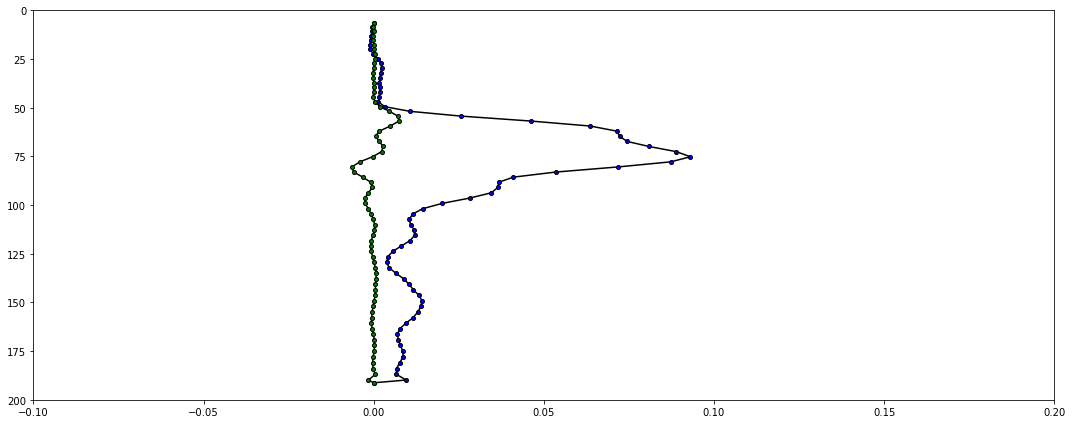

In [11]:
s_t_len = len(sensor_t.time)

deriv1_t = [0. if i == 0 or i == s_t_len - 1 else \
            -(smooth_t[i+1] - smooth_t[i-1])/(sensor_d[i+1] - sensor_d[i-1]) \
                for i in range(s_t_len)]

deriv2_t = [0. if i == 0 or i == s_t_len - 1 else \
            (deriv1_t[i+1] - deriv1_t[i-1])/(sensor_d[i+1] - sensor_d[i-1]) \
                for i in range(s_t_len)]

fig, axs = plt.subplots(1,1,figsize=(15,6), tight_layout=True)

axs.plot(deriv1_t, sensor_d, \
         marker='o', markersize = 4., color='k', markerfacecolor='b')
axs.plot(deriv2_t, sensor_d, \
         marker='o', markersize = 4., color='k', markerfacecolor='g')
axs.set(xlim = (-.1, .2),                                                   \
        ylim = (200., 0.))